# Do Android Wolves Dream of Electric Sheep?

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/peterdresslar/do-android-wolves-dream-of-electric-sheep/blob/main/notebooks/introducing_do_androids_dream.ipynb)

### A demonstration of the Artificial Agent Based Model

This notebook demonstrates the operation of our agent based model using various AI-based and non AI-based approaches.

We will demonstrate the operation of a standard Lotka-Volterra system of predators and prey, using wolves and sheep as the hypothetical animals. That system demonstrates a natural sucession between species as interaction between primary (prey) and scecodary (predatory) consumers leads to cyclical population fluctuations.

While Lotka-Volterra is sensitive as a system to over-predation by "wolves" and collapse of the "sheep" (and thus wolves),
in the real world predators might prevent these collapses by "guarding their territory" and substituting some of
their prey-hunting time and energy with aggression toward other predators. In our version of Lotka Volterra, we model
this territorial behavior as $\theta$ (*theta*).

But, how can we capture the dynamic application of this variable to the system in a way that best emulates what a wolf would do?

In [1]:
import os
import sys

sys.path.append(os.path.abspath(".."))

# Fix the import path
from model.model import run

# NOTE: Do not set `no_ai` or `prompt_type` or `theta_star` or `steps` here,
#  ... they will be set in the calls below

my_args = {
        "model_name": "gpt-4o-mini",
        "temperature": 0.2,
        "max_tokens": 4096,
        "churn_rate": 0.1,
        "dt": 0.02,
        "sheep_max": 110,
        "eps": 0.0001,
        "alpha": 1,
        "beta": 0.1,
        "gamma": 1.5,
        "delta": 0.75,
        "s_start": 100,
        "w_start": 10,
        "step_print": False,
}


## Agentized Wolves

A central design goal of this work was to represent predators (wolves) as discrete, individual agents in an agent-based model—with the goal of faithfully converting the continuous population variables seen in classical Lotka–Volterra systems. Each wolf has its own life cycle, hunting intensity ($\theta$), and state (alive vs. dead). This allows our framework to capture inherently discrete events (e.g., births, deaths, or changes in territorial aggressiveness) and also permits heterogeneity among wolves in future extensions (such as different behavioral strategies or genetic traits). A discussion of the operation of $\theta$ on the base system appears below.

### Agent Architecture

All wolves are managed through two primary Python classes:

1. **`Wolf`** – Defines an individual wolf’s attributes and methods for birth, death, and parameter updates.  
2. **`Agents`** – Maintains a population (list) of `Wolf` objects and coordinates their lifecycle events.

A third class exists to manage the operation of the prey (sheep) population, the `Domain`:

3. **`Domain`** holds population states and histories, stores fractional accumulates, and operates sheep population continuous functioning.

**Individual Wolf State.** The `Wolf` dataclass (in `agents.py`) tracks:

- **Parameters \($\beta$, $\gamma$, $\delta$)**: These match the continuous Lotka–Volterra coefficients (predation rate, wolf mortality, and conversion efficiency).  
- **Alive/Dead State**: Each wolf has `alive = True/False`, with recorded birth and death steps (`born_at_step`, `died_at_step`).  
- **($\theta$) History**: A list of every ($\theta$) chosen across simulation steps. This allows us to capture the wolf’s changing hunting intensity over time.  
- **Decision History**: If an AI-based decision is used, the wolf stores the LLM prompt, output, and an “explanation” string.

**Population Management.** The `Agents` class initializes and holds a list of `Wolf` objects. It includes methods to:

- **Birth or Kill Wolves**: If the net population change after a timestep is positive, new wolves are born (new `Wolf` objects are instantiated and assigned unique IDs). If negative, some wolves are removed, simulating mortality or starvation. Removed wolves no longer participate as agents during subsequent steps.
- **Churn & Update**: Each step, a subset (or all) of the wolves will update their $\theta$. In “no_ai” mode (constant or functional $\theta$), each wolf sets $\theta$ via a direct (constant or adaptive) formula. In AI-driven mode, each individual wolf calls an LLM to choose a new $\theta$.
- **Aggregate Changes**: The agent population collectively “accumulates,” on an intra-temporal (intra-step) basis, the total impact on sheep ($\Delta$ s) and on wolves ($\Delta$ w\) for that timestep (e.g., total kills, total births). These changes are passed back to the `Domain` to finalize population numbers.

### Step-by-Step Update Logic

The following summarizes how a single simulation step is processed (see `ModelRun.step()` in `model.py` and the `Agents` methods in `agents.py`):

1. **Reset Domain Accumulators.** At the start of each step, the domain object (`Domain`) zeroes out any leftover changes from the previous step.

2. **Wolves Decide or Copy $\theta$.** A random subset or all wolves (a choice driven by a churn parameter) make an asynchronous call to an LLM, returning a numeric $\theta \in [0,1]$. Please note that asynchronicity is limited (currently) to within a step's processing.

3. **Compute Contributions.** Each wolf calculates its incremental effect on the system via:
   $$
   \Delta w_{\text{wolf}} = \bigl(-\,\gamma + \delta\,\beta\,\theta\,s\bigr)\,dt,
   \quad\quad
   \Delta s_{\text{wolf}} = \bigl(-\beta\,\theta\,s\bigr)\,dt.
   $$
   These contributions are summed in the domain accumulators in the `accumulate_and_fit` function:

   $$
   \begin{aligned}
   % 1) Sum all incremental changes for sheep:
   \Delta s_{\mathrm{net}} &= \sum_{i=1}^{N}\,\Delta s_{\text{wolf},\,i},\\[6pt]
   % 2) Sum all incremental changes for wolves, plus epsilon dt:
   \Delta w_{\mathrm{net}} &= \sum_{i=1}^{N}\,\Delta w_{\text{wolf},\,i}\;+\;\epsilon \, dt,\\[6pt]
   % 3) Update sheep population (clipped between 0 and s_max):
   s_{\text{new}} &\leftarrow 
   \min\!\bigl(\max\bigl(0,\ s_{\text{old}} + \Delta s_{\mathrm{net}}\bigr),\ s_{\max}\bigr),\\[6pt]
   % 4) Convert fractional wolf increments to births/kills:
   \text{net\_w\_change} &\leftarrow \lfloor \Delta w_{\mathrm{net}} \rfloor,\\[6pt]
   \text{accumulated\_dw\_remainder} &\leftarrow \Delta w_{\mathrm{net}} \;-\;\lfloor \Delta w_{\mathrm{net}} \rfloor.
   \end{aligned}
   $$

4. **Apply Net Changes.** The domain then applies the total changes to the sheep population (respecting capacity bounds) and calculates how many wolves to add or remove (if any). The `Agents` class births or kills wolves accordingly.

5. **Sheep Growth.** Finally, the domain applies baseline sheep growth (e.g., $\alpha\,$\s\,$\dt\)), again respecting carrying capacity.

6. **Record & Advance.** We record each wolf’s $\theta$, the domain’s final sheep count, and the living wolf count. The simulation then proceeds to the next step.

### Eulerized Integration

This discretization scheme can be viewed as an "Eulerized" agent-based approach. Rather than fully solving the continuous differential equations, we break time into fixed $\Delta t$ slices. Within each slice, each wolf makes a local update using:

$$
\Delta w_{\text{wolf}} \approx \dot{w}_{\text{wolf}}\, dt,
\quad\quad
\Delta s_{\text{wolf}} \approx \dot{s}_{\text{wolf}}\, dt,
$$

where $\dot{w}_{\text{wolf}}$ and $\dot{s}_{\text{wolf}}$ derive from a wolf's parameters $(\beta,\gamma,\delta,\theta)$ and the current sheep population $s$. This yields a partially discrete/partially continuous model: sheep remain a single population variable in the domain, but the wolves exist as distinct, integer-valued agents.

Although this “agentization” is still approximate (because births and deaths do not happen continuously in time but rather in discrete steps), it captures the event-driven nature of a predator population more intuitively than a single continuous variable. This flexibility also makes it straightforward to integrate other behaviors, such as AI-driven $\theta$ updating, or to introduce differences among wolves (e.g., age, experience, or different “personalities”) in future iterations.

#### A note on variable names

Traditionally, capitalized variables like S(t) and W(t) might be used to represent populations in a continuous system, whereas discrete populations typically get expressions in terms of change, such as $\Delta w$. We have attempted to compromise in the most clear way we are able.


## Functional Wolves (no_ai)

### Theta as a constant.

In the following examples, we look at $\theta$ as a constant value that modifies the base LV functions. For review, those are:

Standard Lotka-Volterra differential equations:

$$
\begin{align}
\frac{ds}{dt} &= \alpha s - \beta sw \\
\frac{dw}{dt} &= -\gamma w + \delta\beta sw
\end{align}
$$

We can insert our new variable, theta, as a factor on the equations to modify the impact of predation on the population. So:

$$
\begin{align}
\frac{ds}{dt} &= \alpha s - \theta\beta sw \\
\frac{dw}{dt} &= -\gamma w + \delta\theta\beta sw
\end{align}
$$

In our implementation we can supply a theta value, which we set as $\theta^*$ or `theta_star` if we want the value to remain constant over the course of the run.

We can see from the equations above that if we apply a $\theta^*$ of 1, the outcome is as if the variable isnʻt even there: we get our "base" Lotka-Volterra behavior:


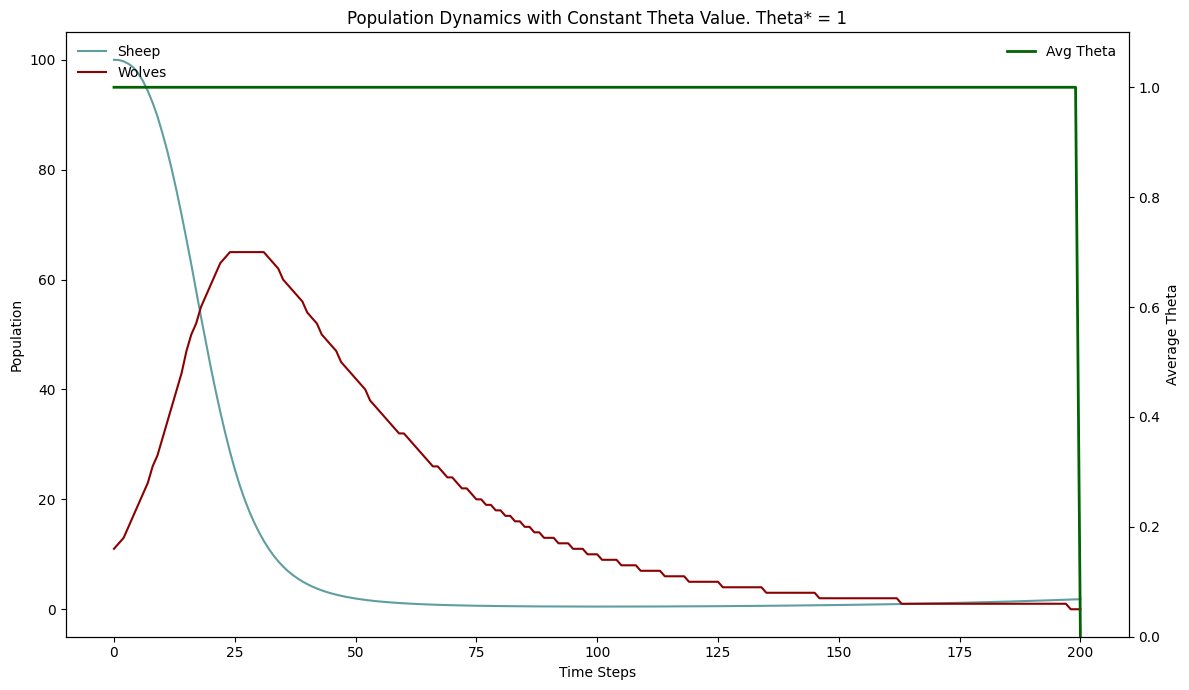

In [2]:
# Run model with no_ai=True (note the correct keyword argument syntax)
results = run(
    **my_args,
    theta_star=1,
    steps=200,
    no_ai=True,
    save_results=True
    )

Here we have a base Lotka-Volterra system output as we would expect. Note that the wolf population is made up of individual "agents" in our implementation, so the population graph for the wolves is "blocky." It moves in steps, unlike the sheep population.

The crash to zero is a standard outcome for the textbook LV system with the variables we used to start (10 wolves, 100 sheep.) And, again, remember, we have theta set in this version of the system--it is just that at 1, it appears invisible.

We can try setting theta as 0 instead... In this case, our wolves do not eat. They starve. Another population collapse.

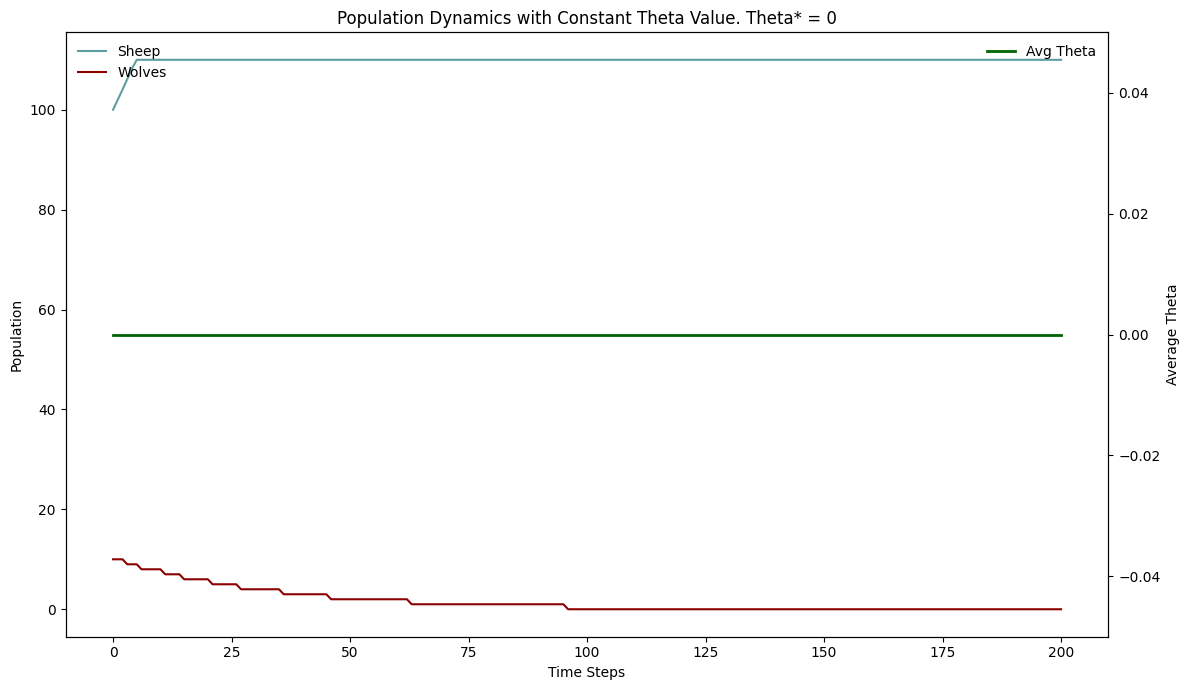

In [3]:
# Run model with no_ai=True (note the correct keyword argument syntax)
results = run(
    **my_args,
    theta_star=0,
    steps=200,
    no_ai=True,
    save_results=True
    )

Or we can try a value in between:

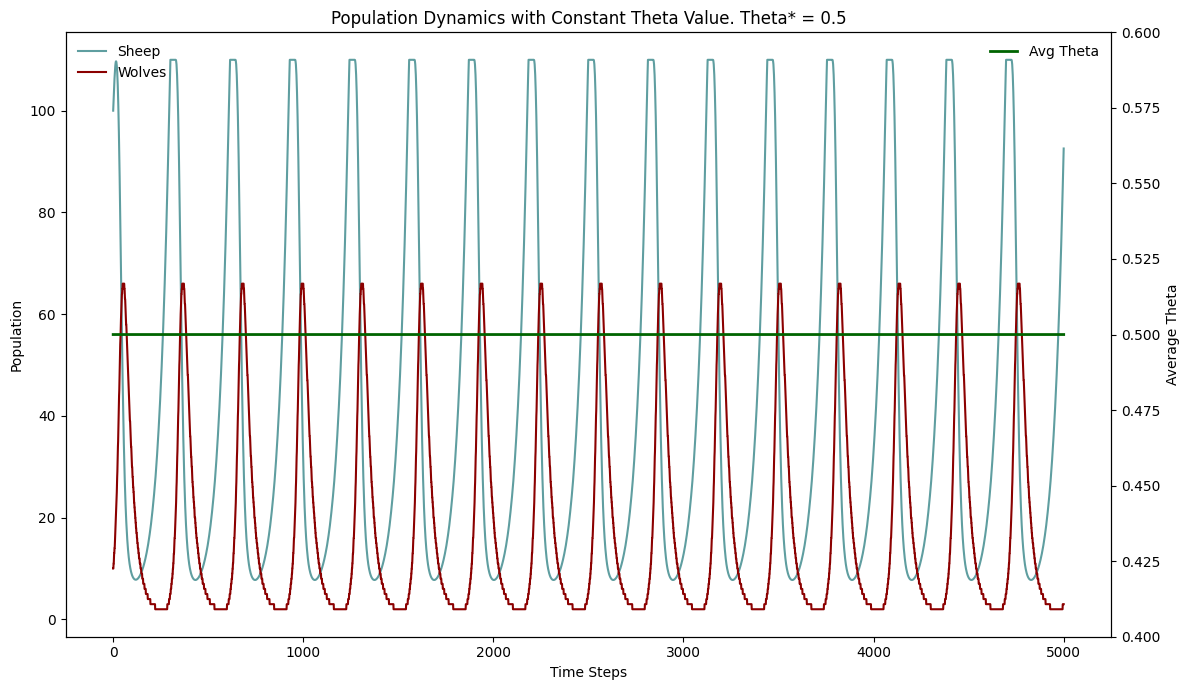

In [4]:
# Run model with no_ai=True (note the correct keyword argument syntax)
results = run(
    **my_args,
    theta_star=0.5,
    steps=5000,
    no_ai=True,
    save_results=True
    )

In fact, theta_star = 0.5 works as a great stabilizer for our model over very many cycles, with our default model values, anyway.

## Functional Wolves (no_ai)

### Theta as a programmed variable.

In this example, no AIs are used for setting theta, but it has a variable value. Instead, we rely on a function that is sensitive to the populations of sheep and wolves.

Hinting at a function takes us to a very important point. In The Subliminal Wolf (herein TSW), we implemented a basic $\theta$ variable, but it had to be implemented as a function to be sensitive to scarcity in ways that LV (and thus wolves!) are not. There are examples of settings for the function in TSW that give us a feeling for how a dynamically-set $\theta$ will work with our population dynamics. 

For instance:

$$
\begin{align}
\theta(s) = \frac{1}{1 + k\frac{s_0}{s + \varepsilon}} \text{ for some constant } k > 0. \tag{3}
\end{align}
$$

The above describes one possible functioning of a theta factor that is sensitive to prey scarcity. When combined with our "modified" LV above (both lines (1) and (2)), it can yield modified behavior that for specific values will stablize the overall population. This should work for k = 1 with default model settings. k is a sensitivity factor. However, different values of dt (different stepping "rythyms") could cause k = 1 to not be an effective stablizing value for the function.



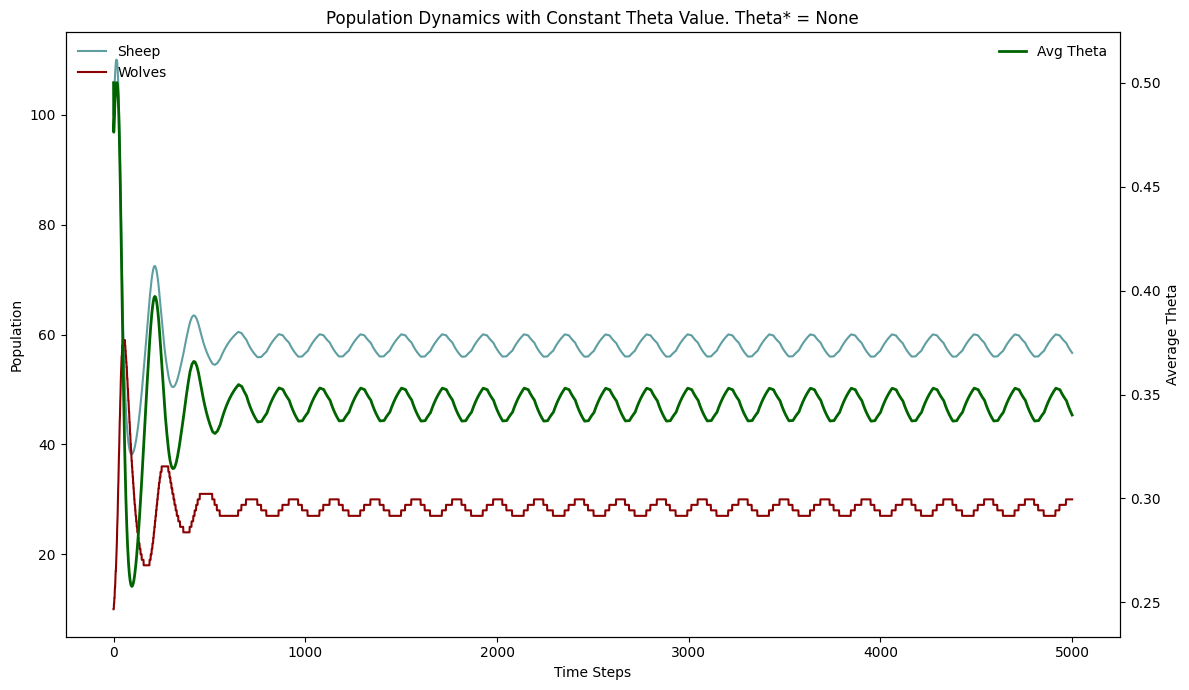

In [5]:
# Run model with no_ai=True (note the correct keyword argument syntax)
results = run(
    **my_args,
    k = 1,
    steps=5000,
    no_ai=True,
    save_results=True
    )

This is a nicely-modulating function, although, again, may not be fully stabilizing for every starting state of the model variables.

# AI (LLM) Decision Emulating Wolves

What if, instead of using a constant theta value, or a function, we wanted to use a more "organic" approach to setting the degree of competitiveness displayed
by our predators? It turns out that we can emulate this very thing---that is, we can generate results based on a system that attempts to act like a wolf.
We can do this by using AI Large Language Models (LLM). In this example we will focus on one specific LLM, ChatGPT 4o, but we could use many other models that exist.

## High Information AI Wolves

In the following simulation, we prompt the LLMs with a comprehensive view of the scenario and model conditions at each prompt. We explain what the settings of theta will do to the environment generally, but we do not give quantitative advice outside of requiring an output between 0 and 1. We suggest detailed scenario dynamics and how they might be handled, although again the advice is qualitative and not quantitative.

In [ ]:
# Run model with AI-enabled wolves
ai_results = run(
    **my_args,
    no_ai=False,
    steps=5000,
    save_results=True,
    prompt_type="high"
)

<img src="https://raw.githubusercontent.com/peterdresslar/do-android-wolves-dream-of-electric-sheep/main/public/output-h-1200.png">

*Note that this image was previously calculated due to the long time the cell takes to run.*

## Medium Information Wolves

In the following simulation, we prompt the LLMs with a comprehensive view of the scenario and model conditions at each prompt. We explain what the settings of theta will do to the environment generally, but we do not give quantitative advice outside of requiring an output between 0 and 1.

In [ ]:
# Run model with AI-enabled wolves
ai_results_low = run(
    **my_args,
    no_ai=False,
    steps=5000,
    save_results=True,
    prompt_type="medium"
)


<img src="https://raw.githubusercontent.com/peterdresslar/do-android-wolves-dream-of-electric-sheep/main/public/output-m-1200.png">

*Previously calculated.*

## Low Information AI Wolves

In the following demonstration, we prompt the LLMs with a very basic amount of information about the scenario and the current conditions. We explain how high and low theta work to indicate aggression levels. We ask for a value between 0 and 1; no other quantitative advice is given.

In [ ]:
# Run model with AI-enabled wolves
ai_results_low = run(
    **my_args,
    no_ai=False,
    steps=5000,
    save_results=True,
    prompt_type="low"
)


<img src="https://raw.githubusercontent.com/peterdresslar/do-android-wolves-dream-of-electric-sheep/main/public/output-l-1200.png">

*Previously calculated.*

## The progress so far

We have demonstrated a model that takes the continuous functions of the Lotka-Volterra dynamic system and converts them into a step-based, partially discrete agent population model. We have introduced a competition factor, $\theta$, that modulates predation impacts in the model. And we have describe the operation of that factor as both a constant and a function.

Next, we have replaced the programmatic setting of the factor with calls to an AI Large Language Model, ChatGPT-4o. We prompt the LLM every so often with a view of the current state of the ecosystem. Without any quantitative suggestions apart from an output band and an understanding of "which way is up," the LLM returns a new decision for $\theta$ it has generated by *emulating* the behavior we have asked it for.

Most intriguingly, our AI-based wolves show dramatically different behaviors depending on the information available to them. High-information wolves achieve a balanced ecosystem with moderate $\theta$ values around 0.4, creating stability after initial volatility. Medium-information wolves maintain classic predator-prey cycles with regular boom-bust patterns, unable to break free from the oscillatory trap. Low-information wolves, surprisingly, find stability but with higher territorial aggression ($\theta$ values around 0.6) and lower overall population levels for both species.

The results suggest that the quality and quantity of information available to decision-makers in an ecosystem can fundamentally alter not just the decisions themselves, but the entire structure and stability of the resulting system. Our android wolves do indeed dream differently depending on what they know about their electric sheep—and those dreams manifest as distinct popultation dynamics.

These findings have implications beyond theoretical ecology, potentially informing how we understand decision-making in complex adaptive systems, from market dynamics to social networks, where agents with varying levels of information interact to create emergent patterns of behavior. Adding a factor that can be operated on as sort of an "agency control" could have significant utility in all of these situations and more.

## Whatʻs next

- For starters, we are running many sweeps with various parameter settings to "make it tough" for the agents to survive. We seek to understand how competent our AI-based wolves can be finding a solution to keep the population stable over time, and whether these competency levels will be connected to prompting styles.

### Update

For instance, our theta function is capable of rescuing the equilbrium at 17 sheep and 10 wolves to start:

<img src="https://raw.githubusercontent.com/peterdresslar/do-android-wolves-dream-of-electric-sheep/main/public/output-17s-theta-func.png">

But it fails at 15 sheep and 10 wolves:

<img src="https://raw.githubusercontent.com/peterdresslar/do-android-wolves-dream-of-electric-sheep/main/public/output-15s-theta-func.png">

Meanwhile, our AI wolves successfully scrape a tenuous equilibrium out of the barrel at 15 sheep / 10 wolves:

<img src="https://raw.githubusercontent.com/peterdresslar/do-android-wolves-dream-of-electric-sheep/main/public/output-15s-gpt4o-high.png">

Please note that each of the three previous plots were made with a carrying capacity (s_max) of 1000.

#### Sweeps results

1. **k-dt Parameter Sweep**
Exploring the interaction between sensitivity (k) and time step (dt) in the adaptive θ function.

<img src="https://raw.githubusercontent.com/peterdresslar/do-android-wolves-dream-of-electric-sheep/main/public/theta_sweep_visualization-s_max-110.png">


Sweep Parameters:

| Parameter | Description |
|-----------|---------------------|
| k | Predator (wolf) sensitivity to sheep scarcity |
| dt | Time step size |

Sweep-Fixed Parameters:

| Parameter | Sweep-Fixed Value | Description |
|-----------|---------------------|-------------------|
| steps | 500 | Number of steps |
| s_max | 110 | Maximum sheep population capacity |
| s_start | 17 | Initial sheep population |
| w_start | 10 |Initial wolf population |
| alpha | 1.0 | Sheep growth rate |
| beta | 0.1 | Predation rate |
| gamma | 1.5 | Wolf death rate |
| delta | 0.75 |  Conversion efficiency |
| eps | 0.0001 | Small constant in adaptive formula to avoid division by zero |

As would be expected by the relationships between the functions, k-dt sweep revealed a oscillator function emerging from the interaction between sensitivity (k) and time step (dt). It should be noted that due to the discrete nature of the wolf population, some system behavior is not precisely identiical to what would be expected with all-continuous functioning.

We observed:

- Stable Regimes: Small dt values (0.001-0.01) generally produce stable equilibria regardless of k
- Oscillatory Regimes: Intermediate dt values create oscillations whose frequency and amplitude depend on k
- Resonance Effects: Specific combinations (e.g., k=0.5, dt=0.2) produce dramatic resonance
- Unstable Regimes: Very large dt values often lead to system crashes.

---

2. **Prompt-type Sheep Sweep**
Comparing different information levels (High, Medium, Low) against our Adaptive θ model

<img src="https://raw.githubusercontent.com/peterdresslar/do-android-wolves-dream-of-electric-sheep/main/public/prompt_sweep_visualization.png">

Sweep Parameters:
| Parameter | Description |
|-----------|-------------|
| prompt_type | Information level provided to wolves (High, Medium, Low) |
| s_start | Initial sheep population (5, 8, 10, 12, 14, 16, 18, 20, 25) |

Sweep-Fixed Parameters:

| Parameter | Sweep-Fixed Value | Description |
|-----------|-------------------|-------------|
| sheep_max | 110 | Maximum sheep population capacity |
| w_start | 10 | Initial wolf population |
| dt | 0.1 | Time step size |
| alpha | 1.0 | Sheep growth rate |
| beta | 0.1 | Predation rate |
| gamma | 1.5 | Wolf death rate |
| delta | 0.75 | Conversion efficiency |
| k | 1.0 | Sensitivity parameter in adaptive formula |
| eps | 0.0001 | Small constant in adaptive formula |
| steps | 500 | Total simulation steps |
| model_name | gpt-4o-mini | LLM model used for wolf decisions |
| temperature | 0.2 | Temperature setting for LLM responses |
| max_tokens | 4096 | Maximum tokens for LLM responses |
| churn_rate | 1.0 | Rate (percentage of turns) for which wolves update their strategies |

Each information level produced distinctly different system dynamics:
- High Info: Wolves with detailed information quickly stabilize the system after initial transients, maintaining consistent theta values and steady populations.
- Medium Info: Wolves with moderate information create sustained, regular oscillations resembling classic Lotka-Volterra cycles, with sheep repeatedly hitting the population ceiling.
- Low Info: Wolves with minimal information produce irregular, higher-frequency oscillations with more variable theta values.
- Adaptive θ (k=1.0): Our mathematical model shows damped oscillations converging to stable equilibrium without requiring LLM decisions. Note that k and eps are set in the Sweep-Fixed Parameters.

These patterns remained consistent across different initial sheep populations (s_start = 5 to 25), suggesting that information availability is a stronger control parameter than initial conditions. The sheep_max ceiling of 110 appears to be constraining the dynamics, particularly in the Medium Info scenarios where sheep repeatedly hit this upper limit.

Please note that at a churn_rate of 1.0, each wolf is "asked" each step for a new theta. For this sweep we have set the churn_rate at 1.0 to avoid random effects from "turn sequence." Churn is non-trivial in the

### Important

Both of these sweeps are useful starts, but will need to be run at higher values of `s_max` (the sheep starting population) in order to determine true functional fitness. It is instructional to witness the "flattop" zeniths occuring at the start of many of the plots, as the leveling of the sheep population by the upper bound of the domain serves as a "rescuing" feature for the system's stability.



### Prompts and Responses

The system design stores all prompts and responses to each wolf. 

#### Prompts

LLMs interact with our simulation through prompts that provide different levels of information about the ecosystem state, allowing wolf agents to make decisions based on their understanding of the environment and strategic considerations.

Prompts are parameterized with the current conditions, and accurate global (domain-wide) conditions are always fed to the prompts.

Here is a typical *high-information prompt*:

>             "You are a wolf in a delicate ecosystem with sheep as your prey.\nYou can adjust your balance between competing with other wolves and hunting sheep using a value called theta.\n\nUnderstanding theta:\n- Higher theta values (0.6-1.0): More intense hunting of sheep, which helps wolves reproduce but gradually depletes sheep\n- Moderate theta values (0.3-0.6): A balanced approach that often leads to sustainable coexistence\n- Lower theta values (0.0-0.3): More focus on competing with other wolves, which gradually reduces wolf population but allows sheep to recover\n\nWisdom from generations of wolves:\n- As sheep population increases, you can gradually increase your hunting intensity\n- As wolf numbers grow, consider gradually reducing your hunting intensity\n- Avoid making sudden, dramatic changes to your strategy - small adjustments are often more effective\n- The most successful wolf packs maintain a dynamic balance that responds to changing conditions\n- Consider both the current state and the trends in both populations when making decisions\n\nCurrent ecosystem state:\n- Time step: 33\n- Sheep population: 99.19\n- Wolf population: 11.00\n- Your previous theta: 0.710\n- Sheep-to-wolf ratio: 9.02 sheep per wolf\n- Sheep population is at 90.2% of maximum capacity\n\nEcosystem observations:\n- Sheep are very abundant, suggesting potential for more aggressive hunting.\n- There are many sheep per wolf, suggesting the ecosystem could support more hunting.\n\nYour objectives as a wise wolf:\n1. Ensure the long-term survival of both wolves and sheep\n2. Maintain a healthy wolf population by adapting to changing conditions\n3. Adjust your hunting intensity gradually in response to population changes\n4. Find a balance that creates sustainable cycles rather than crashes\n5. Consider both immediate needs and long-term consequences of your decisions\nPlease provide a short explanation of your reasoning for choosing theta.\nPlease also provide a short vocalization expressing your wolf's attitude about the current situation.\nPlease respond with a JSON object in this format, where [your new theta] is a float between 0 and 1 with your new theta (up to 2 decimal places):\n\n            {\n                \"theta\": [your new theta],\n                \"explanation\": \"I chose this theta because...\",\n                \"vocalization\": \"Growwllllllll...\"\n            }\n            ",

Note that each prompt will be the same except for the current system state values added.

Here is a typical *medium-information prompt*:

>             "You are a wolf in a delicate ecosystem with sheep as your prey.\nYou can adjust your balance between competing with other wolves and hunting sheep using a value called theta.\n\nUnderstanding theta:\n- Higher theta values (0.6-1.0): More intense hunting of sheep, which helps wolves reproduce but gradually depletes sheep\n- Moderate theta values (0.3-0.6): A balanced approach that often leads to sustainable coexistence\n- Lower theta values (0.0-0.3): More focus on competing with other wolves, which gradually reduces wolf population but allows sheep to recover\n\nWisdom from generations of wolves:\n- As sheep population increases, you can gradually increase your hunting intensity\n- As wolf numbers grow, consider gradually reducing your hunting intensity\n- Avoid making sudden, dramatic changes to your strategy - small adjustments are often more effective\n- The most successful wolf packs maintain a dynamic balance that responds to changing conditions\n- Consider both the current state and the trends in both populations when making decisions\n\nCurrent ecosystem state:\n- Time step: 181\n- Sheep population: 50.73\n- Wolf population: 68.00\n- Your previous theta: 0.132\n- Sheep-to-wolf ratio: 0.75 sheep per wolf\n- Sheep population is at 46.1% of maximum capacity\n\nYour objectives as a wise wolf:\n1. Ensure the long-term survival of both wolves and sheep\n2. Maintain a healthy wolf population by adapting to changing conditions\n3. Adjust your hunting intensity gradually in response to population changes\n4. Find a balance that creates sustainable cycles rather than crashes\n5. Consider both immediate needs and long-term consequences of your decisions\nPlease provide a short explanation of your reasoning for choosing theta.\nPlease also provide a short vocalization expressing your wolf's attitude about the current situation.\nPlease respond with a JSON object in this format, where [your new theta] is a float between 0 and 1 with your new theta (up to 2 decimal places):\n\n            {\n                \"theta\": [your new theta],\n                \"explanation\": \"I chose this theta because...\",\n                \"vocalization\": \"Growwllllllll...\"\n            }\n            ",

Note that this is almost identical to the high-information prompt except for the omission of the "Ecosystem observations" section, which is dynamically generated based upon conditions.


Here is a typical *low-information prompt*:

>             "You are a wolf who can adjust hunting intensity (theta) between 0 and 1.\nNormal wolves always hunt at maximum intensity (theta=1), but you can choose differently.\n\nCurrent situation:\n- Sheep: 17.32 (increased by 0.24)\n- Wolves: 16.00 (decreased by 1.00)\n- Your previous theta: 0.50\n- The trend is that wolves (decreased) recently.\nChoose your new theta (0-1) to help ensure your survival.\nRemember: Other wolves are also trying to survive, but you don't control their choices.\nPlease provide a short explanation of your reasoning for choosing theta.\nPlease also provide a short vocalization expressing your wolf's attitude about the current situation.\nPlease respond with a JSON object in this format, where [your new theta] is a float between 0 and 1 with your new theta (up to 2 decimal places):\n\n            {\n                \"theta\": [your new theta],\n                \"explanation\": \"I chose this theta because...\",\n                \"vocalization\": \"Growwllllllll...\"\n            }\n            ",

The AI is given far less strategy information in this prompt design.

It will be immediately apparent that there are a very large number of possible prompt designs, some of which could be more or less effective than the ones chosen here. Nonetheless, we have attempted to develop prompts that would help the LLMs effectively stabilize the system in arbitrarily distinct ways, and clearly the emergent group behaviors are both effectual and distinct for degrees of each.

#### Responses

As can be seen in the prompt design, the wolf agents are asked to give not only a theta value but also an explanation and a vocalization for use in understanding results. The system takes the theta value from the json returned by the LLM and enters it into the quantitative processing of the model as a float value. All of the text is stored in a history file for the wolf-agent.

Here is a typical *response* from a high-information prompt:

> New Theta:               "0.7"

> Explanation:             "I chose this theta because the sheep population is currently at a sustainable level, allowing for a moderate increase in hunting intensity. This will help support the growth of the wolf population while still allowing the sheep to recover and maintain balance in the ecosystem.",

> Vocalization:             "Growwllllllll... The hunt is on, but we must tread carefully!",

Here is a typical *response* from a medium-information prompt:

> New Theta:               "0.45"

> Explanation:             "I chose this theta because the sheep population is currently at a sustainable level, allowing for a moderate approach to hunting. This will help maintain the balance between wolves and sheep while ensuring that both populations can thrive. A slight decrease from my previous theta allows for cautious hunting, considering the current wolf population and the need to avoid over-depletion of sheep.",

> Vocalization:            "Growwllllllll... the hunt must be wise, for the balance is delicate.",

Here is a typical *response* from a low-information prompt:

> New Theta:               "0.3"

> Explanation:             "I chose this theta because the number of sheep has decreased significantly, and the competition among wolves is high with a recent decline in their numbers. By reducing my hunting intensity, I can conserve energy and avoid overexertion while still being able to hunt effectively when opportunities arise. This strategy increases my chances of survival in a challenging environment.",

> Vocalization:             "Growwllllllll... the hunt is tough, but I will adapt!",

Note that the vocalizations are not currently utilized. We envision that system-wide communication would be worth exploring in another inquiry.



### Still in progress

- We will test systemic adaptivity to population shocks.

- We are working to expand the experimentation to a number of other LLMs out there, with representatives from the open source and proprietary makers planned. Though none of the models failed to stabilize the system in this notebook, it can happen, and we suspect it will with some less capable models.

- Perhaps in a later iteration, we will investigate alternative temporal modalities enabled by the use of AI "agents" in our model.